# Object masks from prompts with SAM

## Environment Set-up

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-defyfpks
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-defyfpks
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=6c330fee2d6c4ad23046eed982be25273c880b95d5599d4e185525fa7bf215c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_lmjg940/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-10 09:20:06--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Example image

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image = cv2.imread('/content/drive/My Drive/Stat_Learn_Final_Proj/#2033_F.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

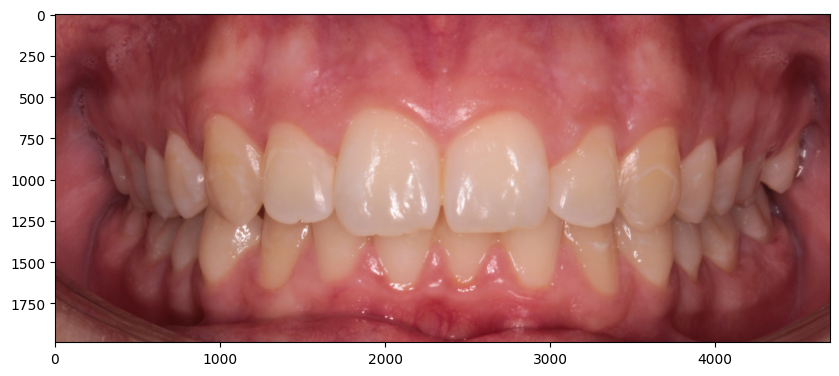

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Resize image

In [ ]:
def resize_image_proportional(image, target_width):

    original_width, original_height = image.shape[1], image.shape[0]
    target_height = int(target_width * original_height / original_width)
    resized_image = cv2.resize(image, (target_width, target_height))

    return resized_image

target_width = 256
resized_image = resize_image_proportional(image, target_width)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
plt.axis('on')
plt.show()

NameError: ignored

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
use_resized_img = True

In [ ]:
if use_resized_img:
  predictor.set_image(resized_image)
else:
  predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [ ]:
if use_resized_img:
  input_point = np.array([[110, 55]])
else:
  input_point = np.array([[2000, 1000]])

input_label = np.array([1])

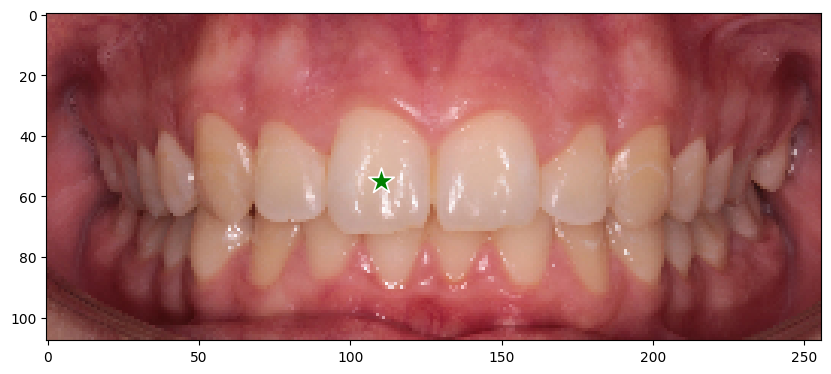

In [ ]:
plt.figure(figsize=(10,10))
if use_resized_img:
  plt.imshow(resized_image)
else:
  plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

(3, 108, 256)

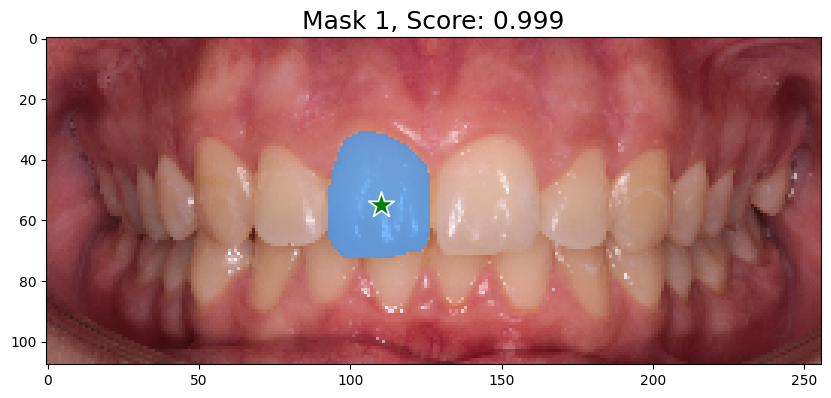

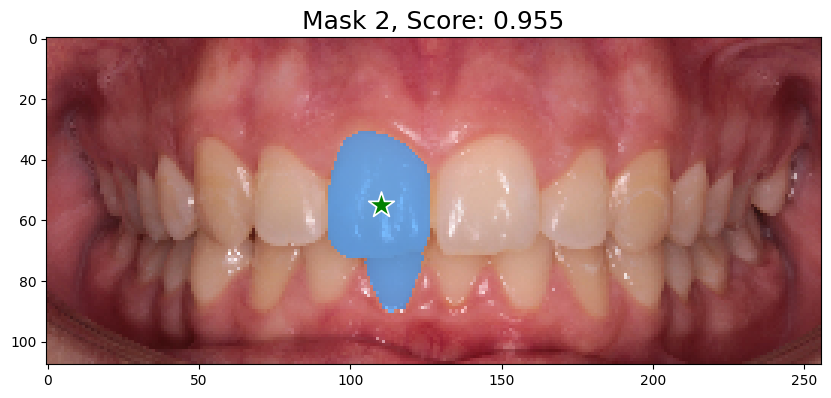

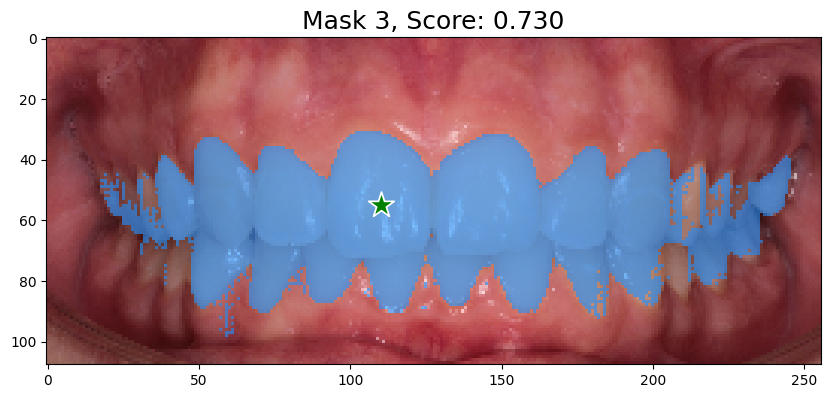

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    if use_resized_img:
      plt.imshow(resized_image)
    else:
      plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    #plt.axis('off')
    plt.show()

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
def resize_factor(value):
  return value / 18.18181818

if use_resized_img:
  input_point = np.array([[resize_factor(2000), resize_factor(1000)], [resize_factor(2500), resize_factor(1000)],
                          [resize_factor(1000), resize_factor(1400)], [resize_factor(3650), resize_factor(1450)]])
else:
  input_point = np.array([[2000, 1000], [2500, 1000], [1000, 1400], [3650, 1450]])

input_label = np.array([1, 1, 1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

(1, 108, 256)

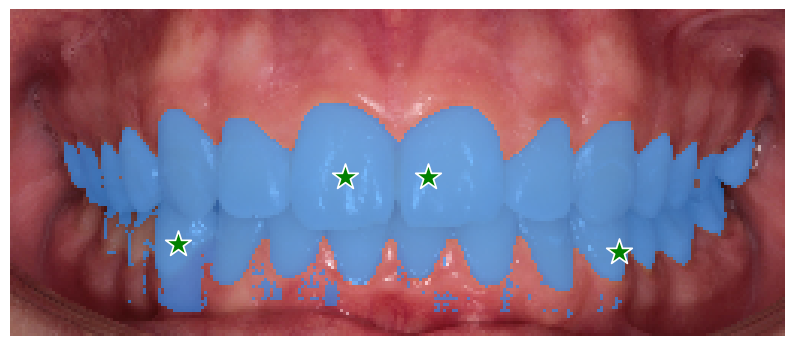

In [ ]:
plt.figure(figsize=(10,10))
if use_resized_img:
  plt.imshow(resized_image)
else:
  plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_point = np.array([[2000, 1000], [2500, 1000], [1000, 1400], [3650, 1450], [1000, 1800], [3650, 1800], [1000, 350], [3650, 350]])
input_label = np.array([1, 1, 1, 1, 0, 0, 0, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

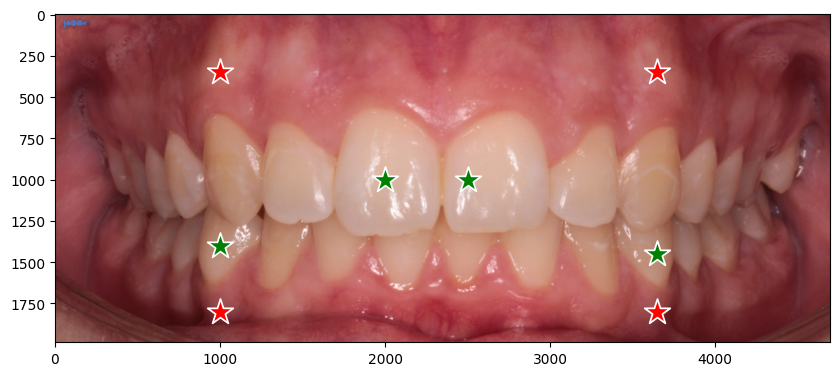

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
#plt.axis('off')
plt.show()

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

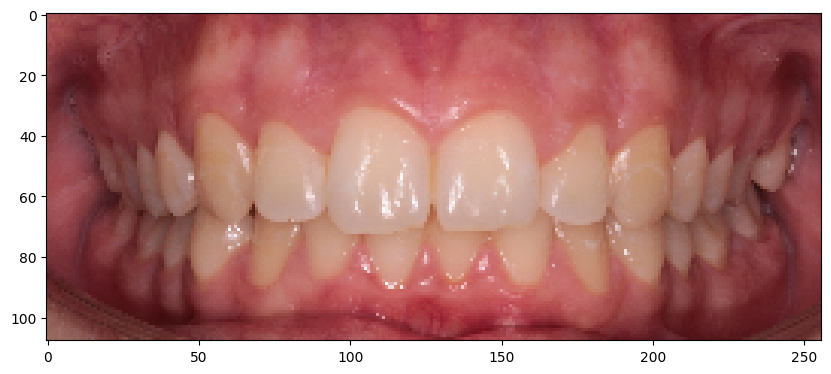

In [ ]:
plt.figure(figsize=(10,10))
if use_resized_img:
  plt.imshow(resized_image)
else:
  plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
input_box = np.array([resize_factor(200), resize_factor(500), resize_factor(4550), resize_factor(1750)])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

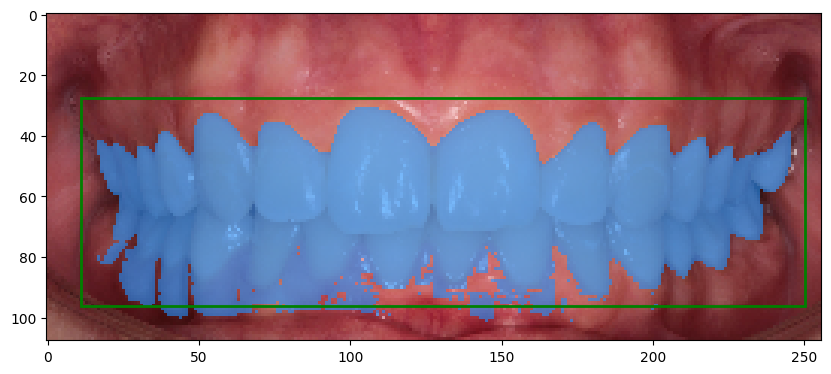

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(resized_image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
#plt.axis('off')
plt.show()

## Keep only the masked part of the image

In [ ]:
import numpy as np

def segment_img(img, mask):

    # Crea un nuovo array per contenere i risultati
    result = np.copy(img)

    # Verifica che gli array abbiano le stesse dimensioni
    if img[:,:,0].shape != mask.shape:
        raise ValueError("Dimensions don't match.")

    # Scorrere gli array e applicare la logica richiesta
    for channel in range(3):

      for i in range(img[:,:,channel].shape[0]):

          for j in range(img[:,:,channel].shape[1]):

              if mask[i, j]:
                  # Se mask contiene True, mantieni il valore numerico
                  pass

              else:
                  # Se mask contiene False, sostituisci il valore numerico con 255
                  result[i, j, channel] = 0

    return result

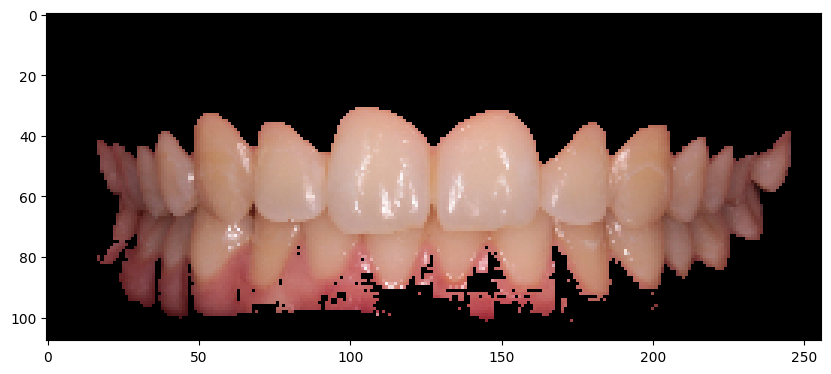

In [ ]:
result = segment_img(resized_image, masks[0])

plt.figure(figsize=(10, 10))
plt.imshow(result);

## Second method

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


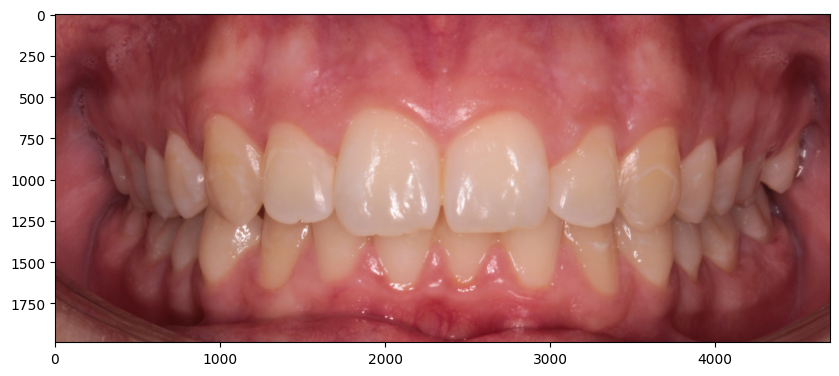

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

img_path = f'/content/drive/My Drive/Stat_Learn_Final_Proj/#2033_F.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

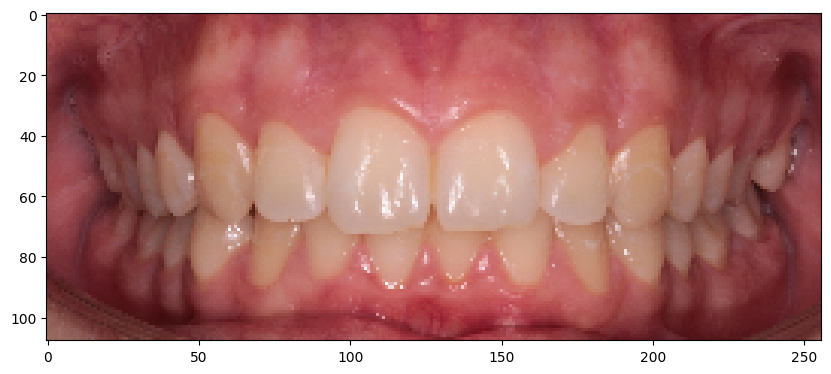

In [ ]:
def resize_image_proportional(image, target_width):

    # Ottieni le dimensioni originali dell'immagine
    original_width, original_height = image.shape[1], image.shape[0]

    # Calcola la nuova altezza in base alla proporzione
    target_height = int(target_width * original_height / original_width)

    # Ridimensiona l'immagine in base alle nuove dimensioni
    resized_image = cv2.resize(image, (target_width, target_height))

    return resized_image

target_width = 256

resized_image = resize_image_proportional(image, target_width)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
plt.show()

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

In [ ]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator_.generate(resized_image)

print(len(masks))

63


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

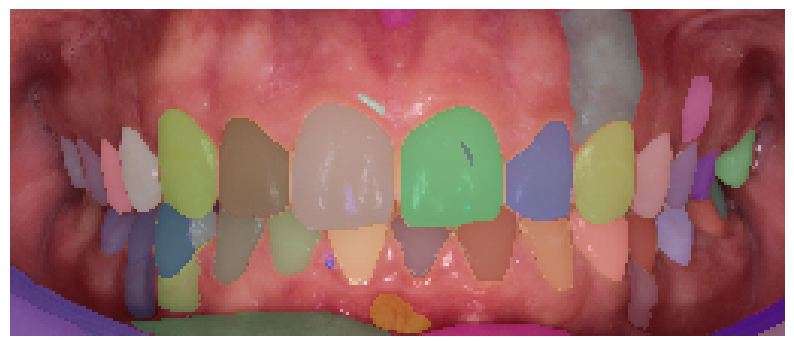

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_anns(masks)
plt.axis('off')
plt.show()

## (Controlled) Automated image segmentation from folder

In [ ]:
import os
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
################################################################################
################################################################################
################################################################################


def resize_image_proportional(image, target_width):

    original_width, original_height = image.shape[1], image.shape[0]
    target_height = int(target_width * original_height / original_width)
    resized_image = cv2.resize(image, (target_width, target_height))

    return resized_image


################################################################################
################################################################################
################################################################################


def segment_image(img, mask, bg_color):

    result = np.copy(img)

    if img[:,:,0].shape != mask.shape:
        raise ValueError("Dimensions don't match.")

    for channel in range(3):
      for i in range(img[:,:,channel].shape[0]):
          for j in range(img[:,:,channel].shape[1]):
              if mask[i, j]:
                  pass
              else:
                  result[i, j, channel] = bg_color

    return result


################################################################################
################################################################################
################################################################################


def create_segmentation(image, bg_color, resize=False, target_width=None):

    if resize is True and target_width is not None:
      image = resize_image_proportional(image, target_width)

    input_box = np.array([10, 5, image[:,:,0].shape[1]-10, image[:,:,0].shape[0]-5])
    print(f'\nInput box: {input_box}\n')
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    show_box(input_box, plt.gca())
    plt.show();

    print("\n")

    while input("\nEnter 'T' to choose the coordinates (xyxy) of a new box.\n") == 'T':
      input_box = np.array(list(map(float, input("\nEnter the new coordinates (xyxy) separated by a blank space.\n").split(' '))))
      print(f'New input box: {input_box}\n')
      plt.figure(figsize=(5, 5))
      plt.imshow(image)
      show_box(input_box, plt.gca())
      plt.show();

    predictor.set_image(image)
    masks, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=input_box[None, :],
      multimask_output=False,
      )

    result = segment_image(image, masks[0], bg_color)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.title('Mask created')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title('Segmented object')

    plt.tight_layout()
    plt.show()

################################################################################
################################################################################
################################################################################

Press 'Enter' to continue or anything else to exit.


Currently working on image "1023.jpg"


Input box: [ 10   5 238  75]



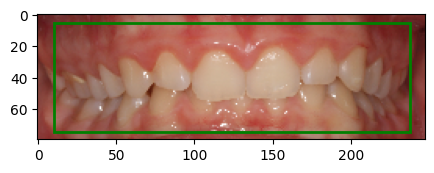




Enter 'T' to choose the coordinates (xyxy) of a new box.



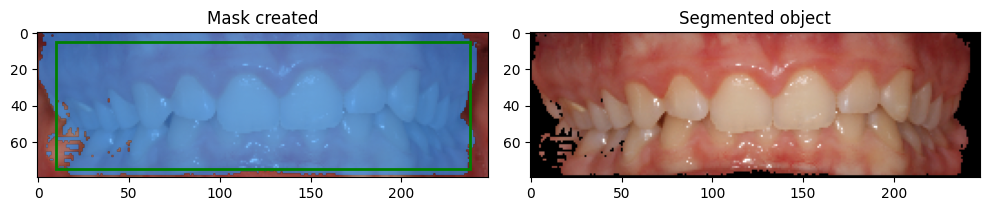

Press 'Enter' to continue or anything else to exit.


Currently working on image "1915.jpg"


Input box: [ 10   5 238  94]



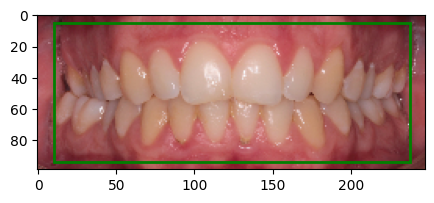




Enter 'T' to choose the coordinates (xyxy) of a new box.



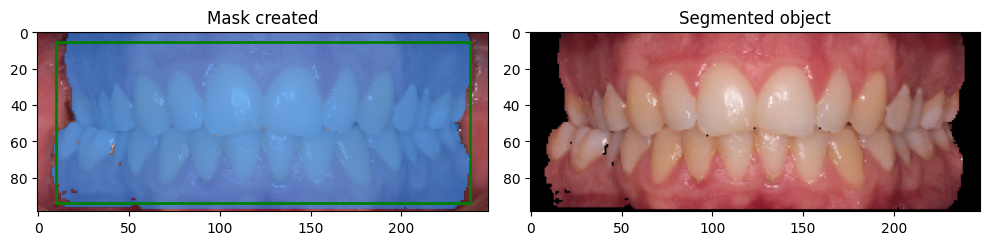

Press 'Enter' to continue or anything else to exit.


Currently working on image "1932.jpg"


Input box: [ 10   5 238  97]



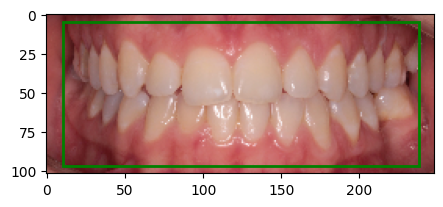




Enter 'T' to choose the coordinates (xyxy) of a new box.
10 20 238 90


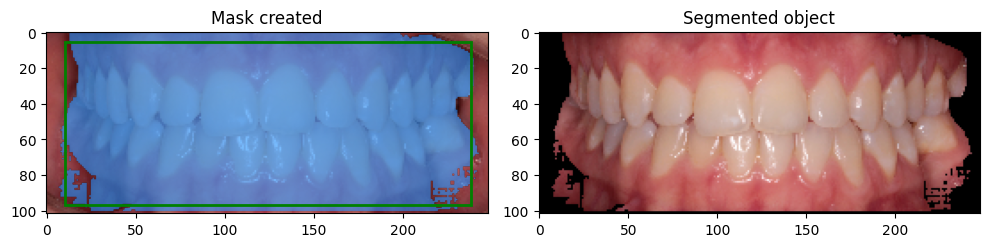

Press 'Enter' to continue or anything else to exit.
x


In [ ]:
bg_color = 0
folder_path = f'/content/drive/My Drive/Stat_Learn_Final_Proj/Dataset_Tagliato/0_Soft/0_Front_view'
images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
target_width = 248

for image in images:

  control = input("Press 'Enter' to continue or anything else to exit.\n")

  if control == "":
    image_path = os.path.join(folder_path, image)
    print(f'\nCurrently working on image "{image}"\n')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    create_segmentation(image=image, bg_color=bg_color, resize=True, target_width=target_width)
  else:
    break